In [1]:
# data retrieval
import requests

# data storage and manipulation
import numpy as np
import pandas as pd

# functional tools to allow for model fine tuning
from functools import partial, update_wrapper

# modeling and validation
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, \
                            precision_score, \
                            recall_score, \
                            confusion_matrix, \
                            f1_score

# from my modeling repo
from indoorplants.analysis import exploratory
from indoorplants.validation import crossvalidate, curves

In [2]:
%matplotlib inline

### --------------------------------------------------------------

# Census Data Analysis

### --------------------------------------------------------------

# 0. Overview

### Prerequisites

This notebook contains the results of a quick exercise in data analysis and prediction, with the goal being to develop a model to predict whether a given person, based on the provided data, makes more than $50K per year.

Depending on which version of Jupyter Notebook you are running, you may have to increase your data transmission limits in order to be able to download the dataset within the confines of the notebook, which is what I have done here. This can be achieved through passing a new limit to the *NotebookApp.iopub_data_rate_limit* option while launching Jupyter Notebook from the command line:
    
    jupyter notebook --NotebookApp.iopub_data_rate_limit=10000000

The original dataset and description can be found at: https://archive.ics.uci.edu/ml/datasets/Adult

### Analysis Description

I put together this analysis in an effort to showcase some analysis & ML-validation modules that I have been working on. The Notebook has 3 parts:

1) Get Data
- Pull dataset from the UC Irvine website
- Check for and deal with duplicates and nulls
- Carry out a slight reworking of table
    
    
2) Exploratory Data Analaysis
- Investigate certain features, looking for relationships with income level
- The approach taken here is visual (and also pretty casual)
- Additionally, provide some descriptions of the dataset
    
    
3) Modeling
- Fit a Random Forest Classifier to the data
- Leverage cross-validationTune to depth parameter to reduce overfitting
- Introduce example business logic and develop custom score function

# 1. Get Data

### Retrieve

In [3]:
def get_census_data():
    cols = ['age', 'workclass', 'fnlwgt', 'education', 
            'education_num', 'marital_status', 'occupation',
            'relationship', 'race', 'sex', 'capital_gain',
            'capital_loss', 'hours_per_week', 'native_country', 
            'over_fifty_k']
    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
    
    with requests.get(url, stream=True) as r:
        results = [l.decode().split(',') for l in r.iter_lines()]
    
    return pd.DataFrame(results, columns=cols)

In [4]:
table = get_census_data()

In [5]:
table.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,over_fifty_k
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [6]:
table.to_csv("cencus_data.csv")

In [7]:
len(table)

32562

### Check for problems

#### Duplicates

In [8]:
len(table[table.duplicated()])

24

In [9]:
table = table.drop_duplicates()

#### Nulls

In [10]:
table.isnull().sum()

age               0
workclass         1
fnlwgt            1
education         1
education_num     1
marital_status    1
occupation        1
relationship      1
race              1
sex               1
capital_gain      1
capital_loss      1
hours_per_week    1
native_country    1
over_fifty_k      1
dtype: int64

In [11]:
table[table.workclass.isnull()]

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,over_fifty_k
32561,,None,None,None,None,None,None,None,None,None,None,None,None,None,None


In [12]:
table[~table.index.isin((32561,))].isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education_num     0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
capital_gain      0
capital_loss      0
hours_per_week    0
native_country    0
over_fifty_k      0
dtype: int64

In [13]:
table = table[~table.index.isin((32561,))].reset_index(drop=True)

### Set up data types

In [14]:
table.dtypes

age               object
workclass         object
fnlwgt            object
education         object
education_num     object
marital_status    object
occupation        object
relationship      object
race              object
sex               object
capital_gain      object
capital_loss      object
hours_per_week    object
native_country    object
over_fifty_k      object
dtype: object

In [15]:
int_cols = ['age', 'fnlwgt', 'capital_gain', 'capital_loss', 'hours_per_week']

In [16]:
table.loc[:, int_cols] = table.loc[:, int_cols].astype(int)

### Set up response column

In [17]:
table.over_fifty_k.value_counts()

 <=50K    24698
 >50K      7839
Name: over_fifty_k, dtype: int64

In [18]:
table.over_fifty_k.unique()

array([' <=50K', ' >50K'], dtype=object)

In [19]:
table.over_fifty_k = table.over_fifty_k.map(lambda _:
                                            1 if _ == ' >50K'
                                            else 0)

# 2. Exploratory Data Analysis

In [20]:
table.over_fifty_k.value_counts() / len(table)

0    0.759074
1    0.240926
Name: over_fifty_k, dtype: float64

#### Notes

The classes are imbalanced, appearing here at a ratio of roughly 3: 1 negative: postitive.

### Age

In [21]:
table.age.nunique()

73

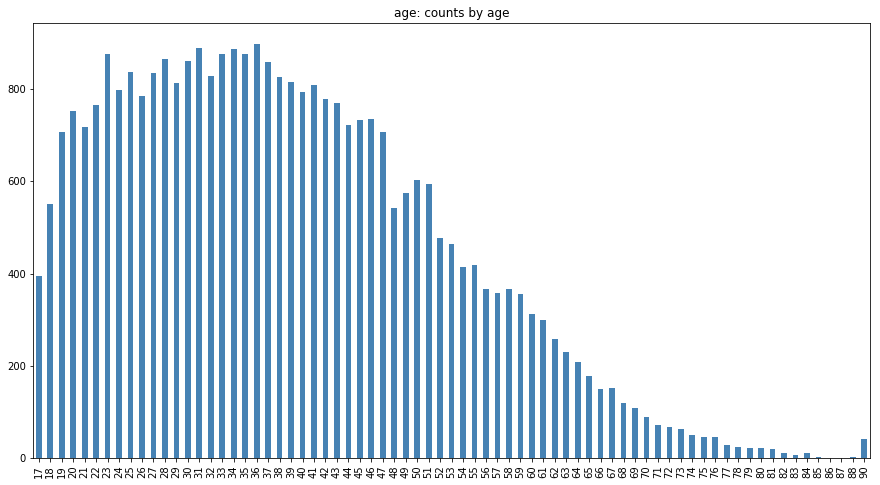

In [22]:
ax = table.age.value_counts().sort_index().plot.bar(figsize=(15, 8), color="steelblue")
ax.title.set_text('age: counts by age')

#### Notes
    
The *age* data looks to be positively skewed, and has a floor of 17.

We can look, in more detail, at the distribution of the *age* data, this time with overlays for the data's mean and strandard deviation, using the `center_scale_plot` function from the **exploratory** module. 

In [ ]:
exploratory.center_scale_plot(table.age, np.mean, np.std, bins=73)

In [ ]:
len(table[table.age > 79]) / len(table)

#### Notes
    
A couple of observations:
- roughly 99.6% of the data falls within 3 standard deviations of the mean, which is 38.6 years
- the concentration of data with age 90 might indicate that age was cut off at 90

In [ ]:
exploratory.qq_plot(table.age.astype(int))

#### Notes

We can use a Q-Q, or quantile-quantile, plot (which in this case plots the quantiles of our data against the quantiles of a Normal distribution with the same mean and standard deviation as the data) to assess whether the data is Normally distributed.

We have an $R^2$ of over 98%, as the vast majority of the data, particularly the data close to the mean, fits the Normal distribution (the straight red line) quite well. However, we can see clearly the deviation from the Normal distribution that occurs in the tails, particularly in the left tail.

The positive skewness makes sense given that the data does not seem to include those under the age of 17.

In [ ]:
exploratory.feature_hist_by_class(table, 'over_fifty_k', 'age', figsize=(15, 8))

#### Notes

Breaking down age by income, we can see that the bulk of the $50K-or-higher earners are middle-aged.

In [ ]:
table['age'] = table.age.astype(int)

### Education

In [ ]:
table.education.nunique()

In [ ]:
ed = table[['education', 'education_num']
          ].drop_duplicates().set_index('education', 
                                        drop=True)

In [ ]:
ed['education_num'] = ed['education_num'].astype(int)

In [ ]:
ed.sort_values('education_num')

#### Notes

There is a one-to-one mapping of *education* to *education_num*. We can retain the ordering here for future analysis of the *education* field. 

In [ ]:
table.education = pd.Categorical(table.education, 
                                 ed.sort_values('education_num').index)

In [ ]:
ax = table['education'].value_counts(
                      ).sort_index(
                      ).plot.bar(figsize=(11, 8), rot=40)
ax.title.set_text('education: histogram')

In [ ]:
exploratory.feature_hist_by_class(table, 'over_fifty_k',
                                  'education', rot=40)

In [ ]:
table['education_num'] = table.education_num.astype(int)

#### Notes

High income is much more prevalent amongst those who went at least as far as to complete high school.

### Education vs. age, by income class

In [ ]:
exploratory.scatter_by_class(table, 'over_fifty_k', 'age', 'education_num')

#### Notes

The more brownish regions in the above plot indicate an overlap between the classes. The bright orange here could indicate some pockets of predominantly over-$50K earners. Let us continue examining other variables to see if a decision boundary becomes more clear. 

### Work class

In [ ]:
table.workclass.nunique()

In [ ]:
ax = table['workclass'].value_counts().sort_index(
                        ).plot.bar(figsize=(11, 8), rot=40)
ax.title.set_text('workclass: histogram')

In [ ]:
exploratory.feature_hist_by_class(table, 'over_fifty_k', 
                                  'workclass', rot=40)

#### Notes

The *Private* employment bucket seem to hold the bulk of the high earners, though most of the people in this bucket in fact do not eclipse $50K in income.

### Final weight

#### Notes

The UCI documentation describes this column as reflecting a by-state population demographic weight. Let's take a look at how this data is distributed. 

In [ ]:
table.fnlwgt.nunique()

In [ ]:
table.fnlwgt = table.fnlwgt.astype(int)

In [ ]:
exploratory.center_scale_plot(table.fnlwgt, np.mean, np.std, bins=100)

In [ ]:
len(table[table.fnlwgt > 506445]) / len(table)

#### Notes

The final weight data exhibits strong positive skewness.

In [ ]:
exploratory.center_scale_plot(np.log(table.fnlwgt), np.mean, np.std, bins=100)

#### Notes

Taking the log transform has yielded a more symmetrical dataset that sits almost entirely within 3 standard deviation bands.

In [ ]:
exploratory.qq_plot(np.log(table.fnlwgt))

#### Notes

Plotting the ordered final weight data against the quantiles of a Normal distribution with the same location and center as the data, we achieve a high goodness-of-fit measure. The unusual lump in the data's left tail stands out on this QQ plot as it did on the above histogram. 

In [ ]:
table['fnlwgt_log'] = np.log(table.fnlwgt)

### Final weight vs. age, by income class

In [ ]:
exploratory.scatter_by_class(table, 'over_fifty_k', 'age', 'fnlwgt_log')

### Final weight vs. education, by income class

In [ ]:
exploratory.scatter_by_class(table, 'over_fifty_k', 'education_num', 'fnlwgt_log')

# 2. Modeling

#### Notes

I am going to keep it simple: one-hot encode the categorical variables, leave the rest in their original states, and see what kind of results can be achieved using a Random Forest Classifier. 

A Decision Tree works by repeatedly splitting a dataset, 20-questions-style, in an effort to find feature values by which the dataset can be seperated into its proper classes. At a high-level, a Random Forest works by creating many different Decision Trees and then averaging its trees predictions to obtain a single value.

RFCs are capable of finding complex decision boundaries, require little with respect to data prep and hyperparameter tuning, and can handle class imbalances in a straightforward manner, through a weighting of the class counts when evaluating splits and making predictions. We will in this case opt for a _balanced subsample_ class weighting. See sklearn [docs](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) for more detail.

### Function to get modeling data

In [ ]:
def get_model_data(table, features, dont_dummy):
    cols = ['over_fifty_k'] + features
    for_modeling = table[cols]
    to_dummy = list(filter(lambda _: _ not in dont_dummy, cols))
    return pd.get_dummies(for_modeling, columns=to_dummy)

### Prep

In [ ]:
table.columns

In [ ]:
table.dtypes

In [ ]:
table[['capital_gain', 
       'capital_loss',
       'hours_per_week']] = table[['capital_gain', 
                                   'capital_loss',
                                   'hours_per_week']
                                  ].astype(int)

In [ ]:
int_cols = list(table.dtypes[table.dtypes=='int64'].index.values)

In [ ]:
int_cols

In [ ]:
X = ['age', 'workclass', 'fnlwgt', 'education_num',
     'marital_status', 'occupation', 'relationship', 
     'race', 'sex', 'capital_gain', 'capital_loss', 
     'hours_per_week', 'native_country']

### Get data

In [ ]:
for_modeling = get_model_data(table, X, int_cols)

In [ ]:
len(for_modeling.columns)

In [ ]:
X_model = [col for col in for_modeling.columns if col != 'over_fifty_k']

In [ ]:
cv, final = train_test_split(for_modeling.index, test_size=.20, 
                             stratify=for_modeling.over_fifty_k)

In [ ]:
final = for_modeling.loc[final, :]

In [ ]:
for_modeling = for_modeling.loc[cv, :]

### Cross validate

#### Notes

Cross validation involves slicing the data into *k* pieces (in this case 5) and, for each of the *k* folds, holding that fold out as a test set (which the model will not be trained on) and training on the rest. 

The results for the tests on each of the folds are then averaged. This methodology solves 2 common problems in model selection: 

- performance figures that stem from predicting the data the model is trained on will be overly optimistic

- the particular subset of the data the model is trained on can bias the hyper-parameter tuning process

We will perform cross validation on 80% of the data (saved into the `for_modeling` table) and we will perform our final tests on the remaining 20% (`final`) so as to avoid reporting final test results based on the data that is used for model selection.

In [ ]:
results = crossvalidate.cv_score(model_obj=RandomForestClassifier(n_estimators=100,
                                                                  class_weight='balanced_subsample'),
                                 X=for_modeling[X_model],
                                 y=for_modeling.over_fifty_k,
                                 score_funcs=[accuracy_score,
                                              precision_score,
                                              recall_score])

In [ ]:
results

#### Analysis

We've trained and tested a Random Forest classifier with 2 hyper parameters passed:

- `n_estimators` determines the number of Decision Trees built

- `class_weight` of *balanced_subsample* tells the algorithm to weight class counts, within each tree, inversely to the prevalence of the classes in the subsample of the data that the tree was built on

Our test *accuracy* of ~85% is on par with the results posted by this dataset's curator. But there are a couple of issues with these results:

- there is a large disparity between train and test results for all 3 of the scores we've calculated

- *accuracy*, especially when dealing with imbalanced classes, can be very misleading

I've included *accuracy* as a sort of quick-n-dirty guide, but the *precision* and *recall* scores here are more important as they are based off of the results for the positive (over-$50K annual income) class, which is less prevalent in the dataset. 

*Precision* tells us how reckless the model was in making its positive predictions. The higher the score, the more careful the model. *Recall* tells us how much money was left on the table, so to speak. The higher the *recall*, the greater the percent of all positive class instances identified.

We can introduce some prepruning, which means limiting the growth of the RFC's internal Decision Trees, so as to curb the overfitting. 

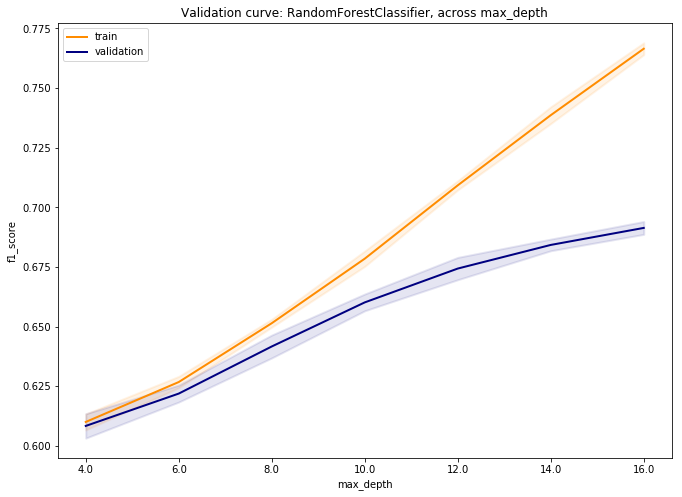

In [64]:
curves.validation_curve(model_type=RandomForestClassifier,
                        X=for_modeling[X_model],
                        y=for_modeling.over_fifty_k,
                        param_name='max_depth',
                        param_range=np.linspace(4, 16, 7),
                        other_params={'class_weight':'balanced_subsample',
                                      'n_estimators':100},
                        score=f1_score)

#### Analysis

The above validation curve plots cross validation performance for the model across different levels of prepruning. The lower `max_depth` is, the stronger the prepruning. As `max_depth` increases, the train and test scores diverge, which is a good sign of overfitting.

The performance metric being used here is called *f1 score*. f1 is the harmonic mean of precision and recall, which means that if you have to choose one number, this can be a good choice as it accounts for both care and thoroughness, so to speak. Additionally, this measure is calculated on the positive class, which means that we will know if our model is simply dumping all predictions into the negative class bucket, a common "gotcha" when dealing with imbalanced classes. 

I am going to continue validation with a `max_depth` of 14, as the train and test divergence is still pretty tame (within 5%), and there does appear to be a gain in validation performance between a `max_depth` of 12 and 14.

In [66]:
r = crossvalidate.cv_conf_mat(model_obj=RandomForestClassifier(n_estimators=100,
                                                               class_weight='balanced_subsample',
                                                               max_depth=14),
                              X=for_modeling[X_model],
                              y=for_modeling.over_fifty_k,
                              splits=3)

In [67]:
r

neg_pred  pos_pred
1 neg_true      5239      1347
  pos_true       293      1798
2 neg_true      5315      1271
  pos_true       320      1770
3 neg_true      5293      1293
  pos_true       336      1754

#### Analysis

To really come to an opinion on how a model's working, it is good to take a look at what's being put where, which is what the above confusion matrices show us (1 for each of 3 trials). It doesn't seem like anything crazy is happening - these numbers reflect what we'd expect from the aggregate scores we looked at above.

### Test situation
    
Taking the confusion matrix further, one can put a value on each type of correct or incorrect prediction. This can make a performance score less abstract and more aligned with a business objective.

Example: you are selling insurance, and a potential client will buy your insurance if the following conditions hold:
1. potential client makes at least $50K annually 
2. potential client is exposed to your insurance product via advertising

It will cost you \$100 to advertise this insurance to a potential client, and you will generate $1000 in revenue if a potential client converts. You need to build a model that will help you decide who to advertise to in order to maximize your simplified gross income of *sales revenue* - *advertising costs*.

#### Set up cost funcs

In [68]:
def cost(true, pred):
    # true negative, no cost
    if true == 0 and pred == 0:
        return 0
    # false positive, lose $100 to advertising
    elif true == 0 and pred == 1:
        return 100
    # false negative, miss out on a grand
    elif true == 1 and pred == 0:
        return 1000
    # true positive, spend $100 to get $1000
    elif true == 1 and pred == 1:
        return -900

In [69]:
def model_cost(y_true, y_pred):
    func = np.vectorize(cost)
    return func(y_true, y_pred).sum()

#### Cross validate

In [70]:
results = crossvalidate.cv_score(model_obj=RandomForestClassifier(
                                                  n_estimators=100,
                                                  class_weight='balanced_subsample',
                                                  max_depth=14),
                                 X=for_modeling[X_model],
                                 y=for_modeling.over_fifty_k,
                                 score_funcs=[model_cost])

In [71]:
results

mean           std
model_cost train -3464200.0  19323.172617
           test   -689920.0  24926.832932

#### Analysis

We've set up an aggressive cost function here where poor *recall* is heavily penalized, which makes sense given the business model. Fortunately, our model is coming in on the right side of zero (this is a measurement of cost so negative is good). 

It's worth noting that there's a large disparity between train and test error. This could be an indication of overfitting. That said, the standard deviation, proportionately speaking, is quite small. Both of these qualities -  overfitting but also consistency - were revealed to us in our learning curve analysis above. 

#### Train / test disparity

I wonder if the disparity between train and test costs may have something to do with the larger size of the training set? (this is an absolute, not %, cost)

In [72]:
results.loc[('model_cost', 'test'), 'mean'
           ] / results.loc[('model_cost', 'train'), 'mean']

0.1991570925466197

Our train data sets used in the CV contained 4 times as much data as our test set did (5-fold validation), and our train score is about 5 times our test score. So we are overfitting, but only by, let's say, 5 or so percent.

#### Next steps

One thing we can do to optimize our cost here is tweak our decision boundary. **sklearn's** models default to a boundary of .5 for binary classification. Since we are much more interested in *recall* than *precision* (we want to nail as many positives as possible and are OK with some false positives) we can lower that decision bounday a bit. In other words, we're going to tell the model to be a little more aggressive in looking for positive classifications. 

We will start with a decision boundary of 40%.

### Adjust boundaries

#### New RF Classifier that predicts probabilities

To do this, we are going to have to put a wrapper around the **sklearn** `RandomForestClassifier` class. These cross-validation tools expect models with an API similar to that of the **sklearn** models, which means they are looking for every model to have a predict method. However, we can change the functionality of a model's predict method so that it predicts class probabilities instead of labels. 

*Note*: I have left this boundary analysis broken out into pieces here in the notebook, but the **indoorplants.validation.boundaries** module provides tools for evaluating binary classifier performance using adjusted decision boundaries.

In [73]:
class RFProb(RandomForestClassifier):
    def predict(self, X):
        return self.predict_proba(X)

#### Modify cost mechanisms to convert probability to label

In [74]:
def prob_to_class(func):
    def convert(y_true, y_pred):
        pos_class = y_pred[:, 1]
        conv = np.vectorize(lambda _: 1 if _ > .4 else 0)
        return func(y_true, conv(pos_class))
    return convert

In [75]:
@prob_to_class
def model_cost(y_true, y_pred):
    func = np.vectorize(cost)
    return func(y_true, y_pred).sum()

#### Cross validate

In [76]:
results40 = crossvalidate.cv_score(model_obj=RFProb(n_estimators=100,
                                   class_weight='balanced_subsample',
                                   max_depth=14),
                                   X=for_modeling[X_model],
                                   y=for_modeling.over_fifty_k,
                                   score_funcs=[model_cost])

In [77]:
results40

mean           std
convert train -3773560.0  21613.606825
        test   -803460.0  13090.569124

In [78]:
results40.loc[('convert', 'test'), 'mean'
             ] / results.loc[('model_cost', 'test'), 'mean']

1.1645698051948052

#### Notes

We have seen an improvement here, subtracting roughly 16% from our test cost. We can push this boundary even further if we'd like.

#### Rework functions to allow for testing across passed thresholds

In [79]:
def cost(true, pred):
    if true == 0 and pred == 0:
        return 0
    elif true == 0 and pred == 1:
        return 100
    elif true == 1 and pred == 0:
        return 1000
    elif true == 1 and pred == 1:
        return -900

In [80]:
def model_cost(y_true, y_pred):
    func = np.vectorize(cost)
    return func(y_true, y_pred).sum()

In [81]:
def prob_to_class(t, func):
    def convert(t, y_true, y_pred):
        pos_class = y_pred[:, 1]
        conv = np.vectorize(lambda _: 1 if _ > t else 0)
        return func(y_true, conv(pos_class))
   
    def threshold(t):    
        partial_func = partial(convert, t)
        update_wrapper(partial_func, convert)
        return partial_func
    
    return threshold(t)

In [82]:
def boundary_cost(t):
    return prob_to_class(t, model_cost)

#### Function to cross validate over multiple boundaries: 5% to 55% 

In [83]:
def test_boundaries():
    i, results = .55, {}
    while i > .05:
        results[i] = crossvalidate.cv_score(
                            model_obj=RFProb(n_estimators=100,
                                             class_weight='balanced_subsample',
                                             max_depth=14),
                            X=for_modeling[X_model],
                            y=for_modeling.over_fifty_k,
                            score_funcs=[boundary_cost(i)])
        i -= .05
    return pd.concat(results)

#### Run cross validation

In [84]:
results = test_boundaries()

In [85]:
results

mean           std
0.05 convert train -3476040.0   5125.231702
             test   -856300.0   1601.561738
0.10 convert train -3689340.0   8595.522090
             test   -891400.0   2912.043956
0.15 convert train -3793180.0   9220.195226
             test   -899260.0   9215.367600
0.20 convert train -3843220.0   9547.617504
             test   -895680.0  11151.098601
0.25 convert train -3872000.0   6129.029287
             test   -880740.0   6900.579686
0.30 convert train -3864740.0   7040.099431
             test   -863380.0   6082.515927
0.35 convert train -3842920.0  16438.278499
             test   -835860.0  10706.446656
0.40 convert train -3764380.0  15149.158392
             test   -804220.0  11262.637347
0.45 convert train -3685860.0   9392.443771
             test   -749240.0  19476.344626
0.50 convert train -3469740.0  18689.917068
             test   -688920.0  25202.321322
0.55 convert train -3160860.0  11172.197635
             test   -611820.0  27026.875513

#### Analysis

The minimum cost (test) was produced with a decision boundary of 15%. However, we see a drastically reduced standard deviation for a decision boundary of 10%.

Of course, whether or not we'd actually want a model this aggressive would depend upon our real-world use case. Seeing as how this is not a real business model, I will continue with a decision threshold of 10%. 

This means that we will advertise to anyone to whom the model assigns at least a 10% probability of earning at least $50K per year.

### Train and test final model

#### Instantiate model

In [96]:
model = RFProb(n_estimators=100,
               class_weight='balanced_subsample',
               max_depth=14)

#### Train

In [97]:
model = model.fit(for_modeling[X_model], for_modeling.over_fifty_k)

#### Predict

In [98]:
y_pred = model.predict(final[X_model])

#### Threshold

In [99]:
def convert(t, y_pred):
    pos_class = y_pred[:, 1]
    conv = np.vectorize(lambda _: 1 if _ > t else 0)
    return conv(pos_class)

In [100]:
y_pred_class = convert(.1, y_pred)

#### Analysis

In [101]:
conf_mat = confusion_matrix(final.over_fifty_k, y_pred_class)

In [102]:
conf_mat

array([[2262, 2678],
       [  19, 1549]])

In [104]:
boundary_cost(.1)(final.over_fifty_k, y_pred)

-1107300

In [105]:
'recall: {}'.format(conf_mat[1][1] / conf_mat[1, :].sum())

'recall: 0.9878826530612245'

In [106]:
'precision: {}'.format(conf_mat[1][1] / conf_mat[:, 1].sum())

'precision: 0.366453749704282'

Testing on our held-out 20% (stratified & randomly selected) of the dataset, we've achieved a positive-class *recall* score of roughly 99%, and a a positive-class *precision* of roughly 37%.

To put it differently, we can see (looking at the above confusion matrix) that we had almost no false negatives, with a whole lot of false positives - about as many (a bit more actually) than there were true negatives.

In a real business situation, you would have to think carefully about how you wanted to score your model's performance. However, we've seen in this exercise that, depending on your situation, it can be worth thinking outside the box (or in the case of the confusion matrix - reinterpreting the box).